In [1]:
import equinox as eqx
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import diffrax
from tqdm.notebook import tqdm

In [2]:
covid_data = jnp.load("covid_data.npy")

mean = jnp.mean(covid_data[:, 1])
std = jnp.std(covid_data[:, 1])
covid_data = covid_data.at[:, 1].set((covid_data[:, 1] - mean) / std)

max_day = jnp.max(covid_data[:, 0])
covid_data = covid_data.at[:, 0].set(covid_data[:, 0] / max_day)

t_eval = covid_data[:, 0]
y_true = covid_data[:, 1]
y0 = covid_data[0, 1]

In [3]:
key = jax.random.PRNGKey(0)
model = eqx.nn.MLP(
    in_size=2, out_size=1, width_size=64, depth=3, activation=jax.nn.tanh, key=key
)

def get_params(model):
    return eqx.filter(model, eqx.is_inexact_array)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(get_params(model))

@eqx.filter_jit
def solve_ode(model, y0, ts):
    f = lambda t, y, model_args: model_args(jnp.stack([y, t])).squeeze()
    term = diffrax.ODETerm(f)
    solver = diffrax.Tsit5()
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0=ts[0],
        t1=ts[-1],
        dt0=1e-2,
        y0=jnp.asarray(y0),
        saveat=diffrax.SaveAt(ts=ts),
        stepsize_controller=diffrax.PIDController(rtol=1e-5, atol=1e-7),
        max_steps=100_000,
        args=model,
        adjoint=diffrax.RecursiveCheckpointAdjoint(),
    )
    return sol.ys

@eqx.filter_value_and_grad
def loss_fn(model, y0, y_true):
    y_pred = solve_ode(model, y0, t_eval)
    return jnp.mean((y_pred - y_true) ** 2)

@eqx.filter_jit
def update(model, opt_state, y0, y_true):
    loss, grads = loss_fn(model, y0, y_true)
    updates, opt_state = optimizer.update(
        grads,
        opt_state,
        params=get_params(model),
    )
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

loss_history = []
for step in tqdm(range(5_000)):
    model, opt_state, loss = update(model, opt_state, y0, y_true)
    loss_history.append(float(loss))

  0%|          | 0/5000 [00:00<?, ?it/s]

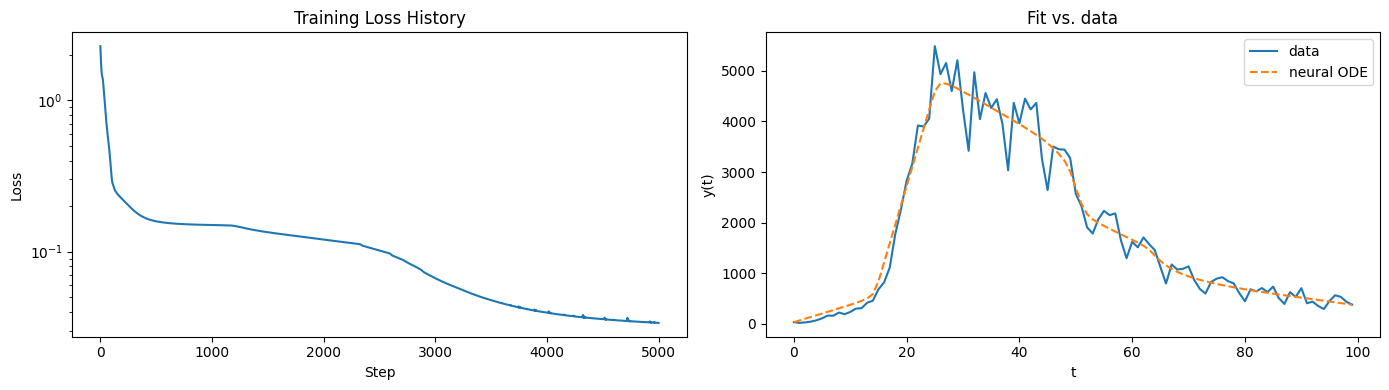

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(loss_history)
axes[0].set_yscale("log")
axes[0].set_xlabel("Step")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training Loss History")

y_pred = solve_ode(model, y0, t_eval)
t = jax.device_get(jnp.asarray(t_eval))
y_fit = jax.device_get(y_pred)
y_obs = jax.device_get(jnp.asarray(y_true))

t_real = t * max_day
y_obs_real = y_obs * std + mean
y_fit_real = y_fit * std + mean

axes[1].plot(t_real, y_obs_real, label="data")
axes[1].plot(t_real, y_fit_real, "--", label="neural ODE")
axes[1].set_xlabel("t")
axes[1].set_ylabel("y(t)")
axes[1].set_title("Fit vs. data")
axes[1].legend()

plt.tight_layout()
plt.show()

jnp.save("covid_fit.npy", y_fit_real)

In [5]:
covid_fit = jnp.load("covid_fit.npy")
print("Predicted data shape:", covid_fit.shape)
print("Predicted data (first 10 entries):", covid_fit[:10])
print("Predicted data (last 10 entries):", covid_fit[-10:])
print("Highest predicted entry:", jnp.max(covid_fit))

Predicted data shape: (100,)
Predicted data (first 10 entries): [ 33.000122  66.98303  100.98303  135.00671  169.06604  203.18494
 237.3977   271.75037  306.32214  341.2666  ]
Predicted data (last 10 entries): [518.2555  502.8551  487.47327 472.0735  456.62854 441.109   425.4889
 409.74585 393.85364 377.7965 ]
Highest predicted entry: 4752.7246


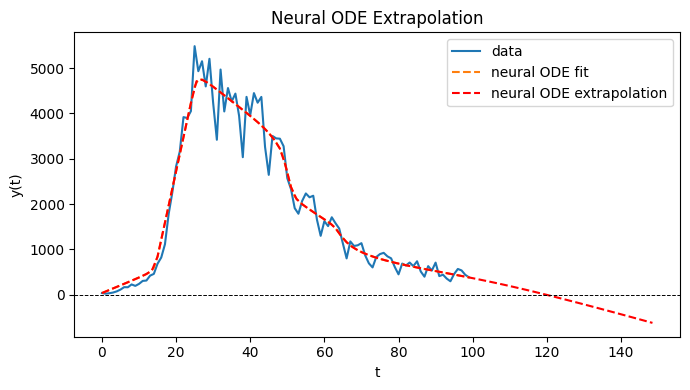

In [ ]:
# Bonus - extrapolation
t_extrap = jnp.linspace(0, 1.5, 100)
y_extrap = solve_ode(model, y0, t_extrap)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(t_real, y_obs_real, label="data")
ax.plot(t_real, y_fit_real, "--", label="neural ODE fit")
ax.plot(t_extrap * max_day, (y_extrap * std + mean), "r--", label="neural ODE extrapolation")
ax.set_xlabel("t") 
ax.set_ylabel("y(t)")
ax.set_title("Neural ODE Extrapolation")
ax.axhline(0, color='black', linestyle='--', linewidth=0.7)
ax.legend()
plt.tight_layout()
plt.show()